# Analyze Samples
## Imports

In [1]:
import os
import random

from tlib import tlearn, tgeo, tutils
from projects.testbed18 import config, utils

from api_coverages import get_coverage

%load_ext autoreload
%autoreload 2

## Configuration

In [2]:
#collection = 'collections/s2_anthropo'
collection = 'collections/s2_investigative'
#bbox = [16.7, 59.7, 16.825, 59.825] # -> 1250 x 1250 pixels
#bbox = [16.8, 59.8, 16.8251, 59.825] # -> 250 x 250 pixels
#bbox = [20.27080771398277, 66.45825882626778, 20.495119661234394, 66.55002311657806] # paper figure 8
#bbox = [10.434810477469897, 62.019114499434934, 10.836427562826682, 62.1989645072601] # paper figure 9 (2017)
#bbox = [10.434810477469897, 62.019114499434934, 10.836427562826682, 62.1989645072601] # paper figure 9 (2020)
#bbox = [26.12659400833689, 65.34754243953564, 26.341300676504012, 65.43979470854401] # paper figure 10
bbox = [20.27, 66.45, 20.39, 66.57]
bands = None  # e.g.'blue, green, red'

## Download data from API Coverages

In [3]:
collection_url = config.server_url + collection

In [4]:
result = get_coverage(collection_url, bbox, bands)
dataset = result.open()

Requesting coverage from 'https://18.testbed.dev.52north.org/geodatacube/collections/s2_investigative/coverage?f=GeoTIFF&bbox=20.27,66.45,20.39,66.57'


In [5]:
images = dataset.read()

In [11]:
# ToDo: add in pygeoapi_odc_provider
#channel_names = dataset.descriptions
#titles = ['blue', 'green', 'red', 'vegetation_red_edge1', 'vegetation_red_edge2', 'vegetation_red_edge3',
#          'nir', 'narrow_nir', 'swir1', 'swir2']

## Setup Files and Plotter

In [6]:
channel_indices = {'B2': 0, 'B3': 1, 'B4': 2, 'B5': 3, 'B6': 4, 'B7': 5, 'B8': 6, 'B8A': 7, 'B11': 8, 'B12': 9}

In [7]:
files = ['/home/martin/Projekte/OGC_Testbed-18/data/anthroprotect/investigative/inv_hydroelectric-letsi_2019-07-01-2019-08-30.tif']

In [8]:
from projects.testbed18 import data

labels = [0] * len([result])
# trainer = utils.load_trainer()
# trainer.datamodule.dataset_kwargs
dataset_kwargs = {
        'channels': None,
        'x_normalization': (0, 10000),
        'clip_range': (0, 1),
        'y_normalization': None,
        'n_classes': 1,
        'use_rasterio': True,
        'rgb_channels': [2, 1, 0],
        'val_range': (0, 1024)
    }

dataset = data.DatasetOriginal(files=[result], labels=labels, **dataset_kwargs)

In [9]:
#input = files[0]
input_data = result

## Plot Sentinel-2 data

In [10]:
s2_plotter_generic = utils.GenericS2Plotter()

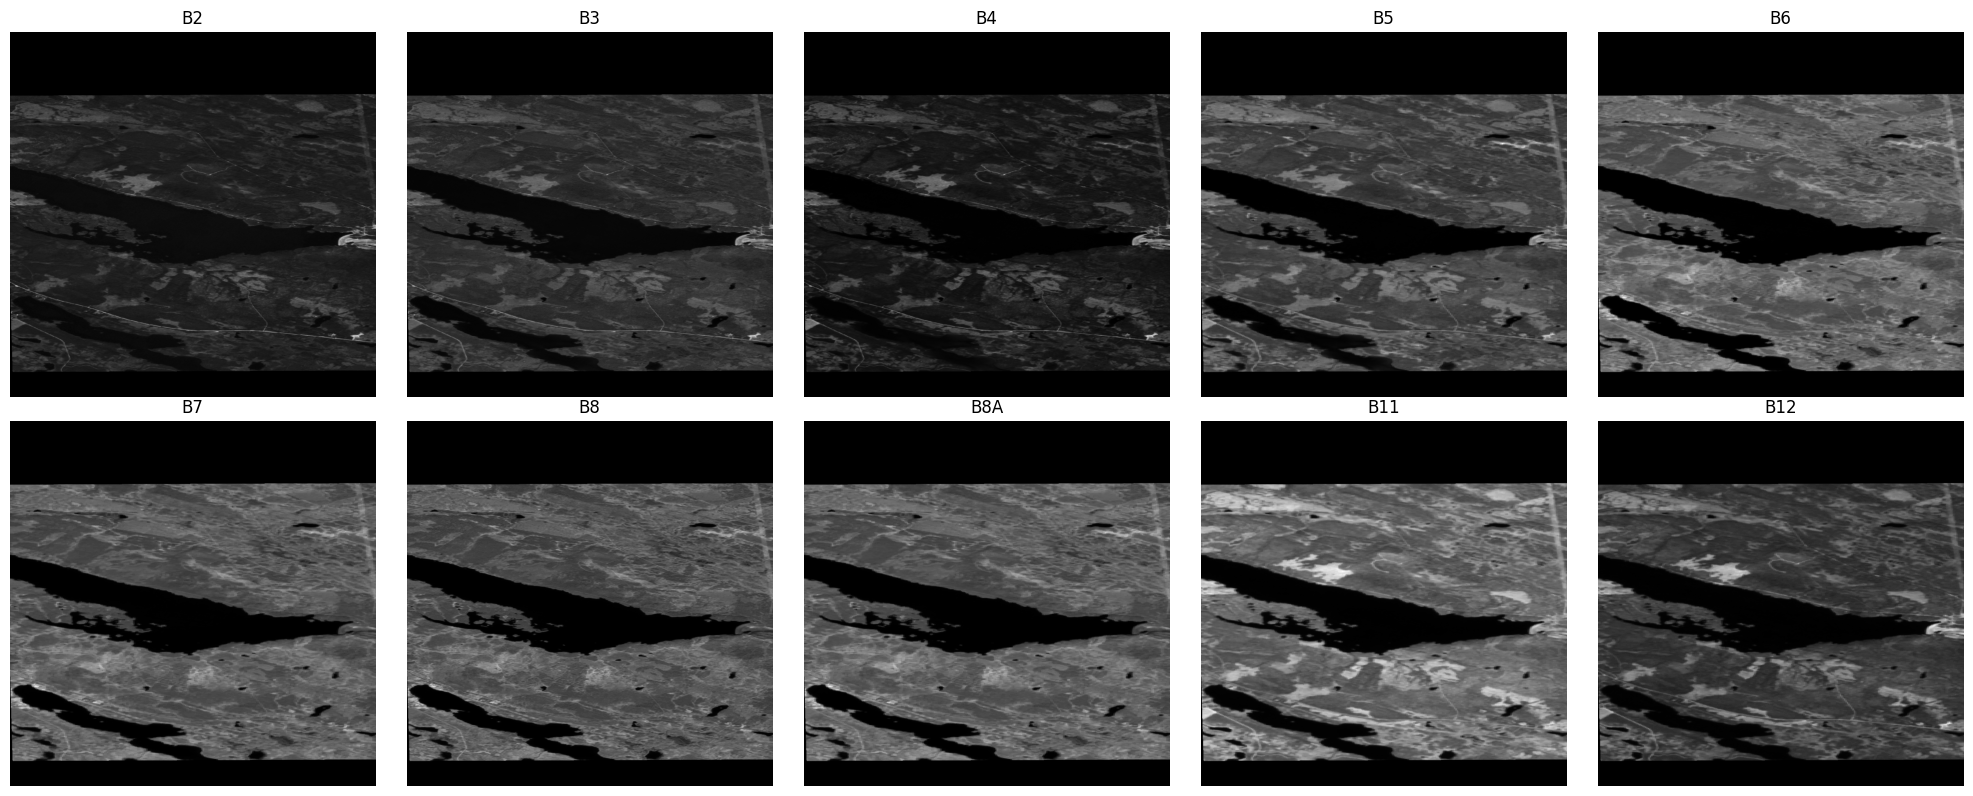

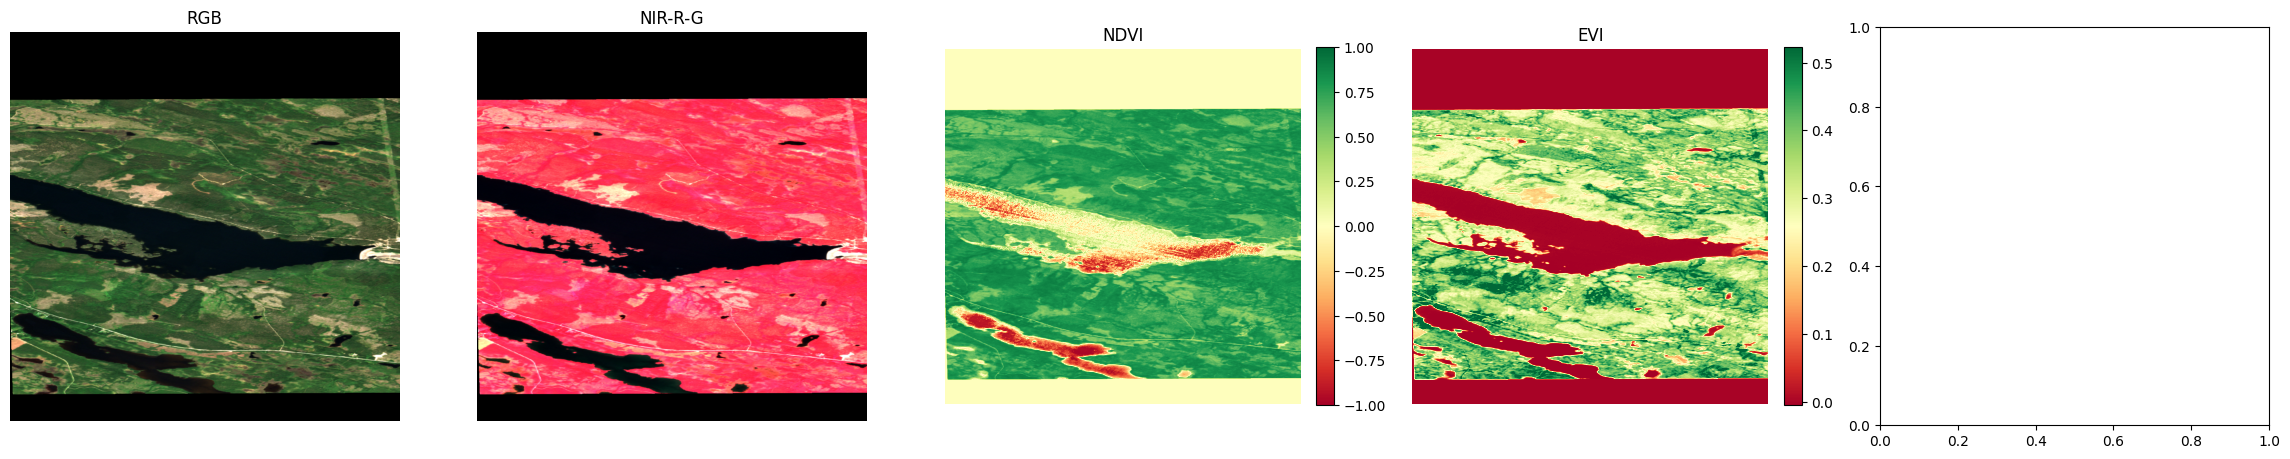

In [11]:
s2_plotter_generic.plot(
    images,
    figsize=(4 * 5, 4 * 2)
)

## Predict activation map

In [12]:
unet_map = utils.predict_activation_maps(input_data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.17s/it]


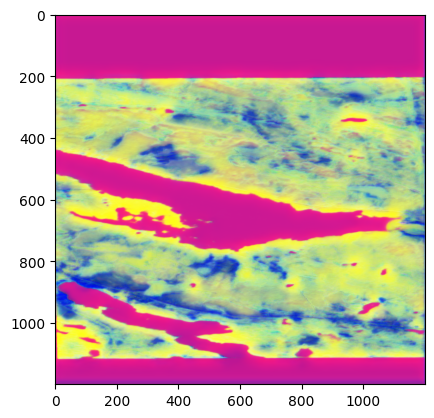

In [14]:
from matplotlib import pyplot as plt
import numpy as np
plt.imshow((np.array(unet_map)[0].transpose(1,2,0)+1)/2)

## Predict  sensitivity map

In [15]:
sensitivities = utils.predict_sensitivity_maps(input_data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/it]


predicting groups:   0%|          | 0/981 [00:00<?, ?it/s]

predicting sensitivities:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
asos = utils.load_asos()

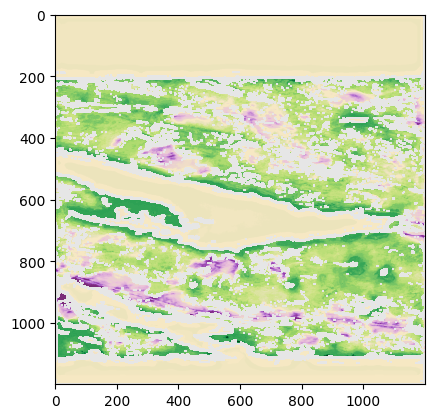

In [17]:
plt.imshow(sensitivities[0], cmap=asos.cmap, vmin=-asos.vlim, vmax=asos.vlim)

## All Files to RGB Tiff
Note: If you do not have a trained model, yet, you can ignore some of the plot_kwargs! To plot them, you need to predict the image.

In [ ]:
output_folder = os.path.join(config.working_dir, 'rgbs')  # os.path.join(utils.load_trainer().log_dir, 'rgbs')

In [ ]:
# plotter
s2_plotter.val_range_s2 = (0, 2**10.5)
s2_plotter.to_tif(
    *files,
    output_folder=output_folder,
    
    plot_rgb=True,
    #plot_false_colors=True,
    #plot_channels=['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'],
    #plot_ndvi=True,
    #plot_evi=True,
    #plot_scl=True,
    #plot_lcs=['CORINE', 'MODIS_1', 'CGLS', 'GlobCover'],  # ['CORINE', 'MODIS_1', 'CGLS', 'GlobCover']
    #plot_masks=['BB'],#['ROI', 'Valid_Area'],  # ['ROI', 'Valid_Area']
)

asos_plotter.to_tif(
    *files,
    output_folder=output_folder,
    
    plot_unet_maps=True,
    #plot_all_unet_maps=True,
    plot_sensitivities=True,
    #plot_osms=True,

    batch_size=batch_size,
)